# Install PyGeNN wheel from Google Drive
Download wheel file

In [1]:
if "google.colab" in str(get_ipython()):
    #import IPython
    #IPython.core.magics.execution.ExecutionMagics.run.func_defaults[2] = lambda a: a
    #%run "../install_collab.ipynb"
    !pip install gdown --upgrade
    !gdown 1V_GzXUDzcFz9QDIpxAD8QNEglcSipssW
    !pip install pygenn-5.0.0-cp310-cp310-linux_x86_64.whl
    %env CUDA_PATH=/usr/local/cuda

Downloading...
From: https://drive.google.com/uc?id=1V_GzXUDzcFz9QDIpxAD8QNEglcSipssW
To: /content/pygenn-5.0.0-cp310-cp310-linux_x86_64.whl
100% 8.29M/8.29M [00:00<00:00, 101MB/s]
Processing ./pygenn-5.0.0-cp310-cp310-linux_x86_64.whl
pygenn is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
env: CUDA_PATH=/usr/local/cuda


## Install MNIST package

In [2]:
!pip install mnist

# Build tutorial model
Import modules

In [3]:
import mnist
import numpy as np
from copy import copy
from matplotlib import pyplot as plt
from pygenn import (create_current_source_model, create_neuron_model, create_weight_update_model,
                    init_postsynaptic, init_sparse_connectivity, init_weight_update, GeNNModel)

# Reshape and normalise training data
training_images = mnist.train_images()
training_images = np.reshape(training_images, (training_images.shape[0], -1)).astype(np.float32)
training_images /= np.sum(training_images, axis=1)[:, np.newaxis]
training_labels = mnist.train_labels()

In [4]:
from tqdm.auto import tqdm

## Parameters
Define some model parameters

In [5]:
# Simulation time step
DT = 0.1

# Scaling factor for converting normalised image pixels to input currents (nA)
INPUT_SCALE = 80.0

# Number of Projection Neurons in model (should match image size)
NUM_PN = 784

# Number of Kenyon Cells in model (defines memory capacity)
NUM_KC = 20000

# How long to present each image to model
PRESENT_TIME_MS = 20.0

# Standard LIF neurons parameters
LIF_PARAMS = {
    "C": 0.2,
    "TauM": 20.0,
    "Vrest": -60.0,
    "Vreset": -60.0,
    "Vthresh": -50.0,
    "Ioffset": 0.0,
    "TauRefrac": 2.0}

# We only want PNs to spike once
PN_PARAMS = copy(LIF_PARAMS)
PN_PARAMS["TauRefrac"] = 100.0

# Weight of each synaptic connection
PN_KC_WEIGHT = 0.2

# Time constant of synaptic integration
PN_KC_TAU_SYN = 3.0

# How many projection neurons should be connected to each Kenyon Cell
PN_KC_FAN_IN = 20

# We will use weights of 1.0 for KC->GGN connections and
# want the GGN to inhibit the KCs after 200 spikes
GGN_PARAMS = {
    "Vthresh": 200.0}

As we're now going to be adding our synaptic connections between the Projection Neurons and a new population of Kenyon Cells, also define some parameter for these

In [6]:
NUM_MBON = 10
MBON_STIMULUS_CURRENT = 5.0

In [7]:
KC_MBON_TAU_SYN = 3.0
KC_MBON_PARAMS = {"tau": 15.0,
                  "rho": 0.01,
                  "eta": 0.00002,
                  "wMin": 0.0,
                  "wMax": 0.0233}

# Custom models
As well as the models we defined before:

In [8]:
# Current source model, allowing current to be injected into neuron from variable
cs_model = create_current_source_model(
    "cs_model",
    vars=[("magnitude", "scalar")],
    injection_code="injectCurrent(magnitude);")

# Minimal integrate and fire neuron model
if_model = create_neuron_model(
    "IF",
    params=["Vthresh"],
    vars=[("V", "scalar")],
    sim_code=
    """
    V += Isyn;
    """,
    threshold_condition_code=
    """
    V >= Vthresh
    """,
    reset_code=
    """
    V = 0.0;
    """)

We now also need an STDP learning rule!

In [9]:
symmetric_stdp = create_weight_update_model(
    "symmetric_stdp",
    params=["tau", "rho", "eta", "wMin", "wMax"],
    vars=[("g", "scalar")],
    pre_spike_syn_code=
    """
    const scalar dt = t - st_post;
    const scalar timing = exp(-dt / tau) - rho;
    const scalar newWeight = g + (eta * timing);
    g = fmin(wMax, fmax(wMin, newWeight));
    """,
    post_spike_syn_code=
    """
    const scalar dt = t - st_pre;
    const scalar timing = fmax(exp(-dt / tau) - rho, -0.1*rho);
    const scalar newWeight = g + (eta * timing);
    g = fmin(wMax, fmax(wMin, newWeight));
    """)


## Model definition
Create a new model called "mnist_mb_second_layer_gain_control" as before although we no longer need to record spikes from individual neurons:

In [10]:
# Create model
model = GeNNModel("float", "mnist_mb_third_layer")
model.dt = DT

# Create neuron populations
lif_init = {"V": PN_PARAMS["Vreset"], "RefracTime": 0.0}
if_init = {"V": 0.0}
pn = model.add_neuron_population("pn", NUM_PN, "LIF", PN_PARAMS, lif_init)
kc = model.add_neuron_population("kc", NUM_KC, "LIF", LIF_PARAMS, lif_init)
ggn = model.add_neuron_population("ggn", 1, if_model, GGN_PARAMS, if_init)

# Turn on spike recording
pn.spike_recording_enabled = True
kc.spike_recording_enabled = True

# Create current sources to deliver input to network
pn_input = model.add_current_source("pn_input", cs_model, pn , {}, {"magnitude": 0.0})

# Create synapse populations
pn_kc = model.add_synapse_population("pn_kc", "SPARSE",
                                     pn, kc,
                                     init_weight_update("StaticPulseConstantWeight", {"g": PN_KC_WEIGHT}),
                                     init_postsynaptic("ExpCurr", {"tau": PN_KC_TAU_SYN}),
                                     init_sparse_connectivity("FixedNumberPreWithReplacement", {"num": PN_KC_FAN_IN}))

kc_ggn = model.add_synapse_population("kc_ggn", "DENSE",
                                      kc, ggn,
                                      init_weight_update("StaticPulseConstantWeight", {"g": 1.0}),
                                      init_postsynaptic("DeltaCurr"))

ggn_kc = model.add_synapse_population("ggn_kc", "DENSE",
                                      ggn, kc,
                                      init_weight_update("StaticPulseConstantWeight", {"g": -5.0}),
                                      init_postsynaptic("ExpCurr", {"tau": 5.0}))

Add a current source to inject current into `pn` using our newly-defined custom model with the initial magnitude set to zero.

In [11]:
mbon = model.add_neuron_population("mbon", NUM_MBON, "LIF", LIF_PARAMS, lif_init)

mbon.spike_recording_enabled = True

# Create current sources to deliver input and supervision to network
mbon_input = model.add_current_source("mbon_input", cs_model, mbon , {}, {"magnitude": 0.0})

Add a new synapse group connecting ``kc`` into ``mbon`` with initially zeroed weights and our newly-defined STDP rule.

In [12]:
kc_mbon = model.add_synapse_population("kc_mbon", "DENSE",
                                       kc, mbon,
                                       init_weight_update(symmetric_stdp, KC_MBON_PARAMS, {"g": 0.0}),
                                       init_postsynaptic("ExpCurr", {"tau": KC_MBON_TAU_SYN}))

## Build model
Generate code and load it into PyGeNN (as we're no longer recording spikes, we don't need to allocate a recording buffer)

In [13]:
# Convert present time into timesteps
present_timesteps = int(round(PRESENT_TIME_MS / DT))

# Build model and load it
model.build()
model.load(num_recording_timesteps=present_timesteps)

# Simulate tutorial model
As well as resetting the state of every neuron after presenting each stimuli, because we have now added synapses with their own dynamics, these also need to be reset.
 This function resets neuron state variables selected by the keys of a dictionary to the values specifed in the dictionary values and pushes the new values to the GPU.

Now, like before, we loop through 4 stimuli and simulate the model. However, now we need to reset the Projection Neuron and Kenyon Cell populations; **and** the synapses between them. Additionally, we want to show spikes from the Kenyon Cells as well as the Projection Neurons.

In [14]:
def reset_spike_times(pop):
    pop.spike_times.view[:] = -np.finfo(np.float32).max
    pop.spike_times.push_to_device()

In [15]:
def reset_out_post(pop):
    pop.out_post.view[:] = 0.0
    pop.out_post.push_to_device()

def reset_neuron(pop, var_init):
    # Reset variables
    for var_name, var_val in var_init.items():
        pop.vars[var_name].view[:] = var_val

        # Push the new values to GPU
        pop.vars[var_name].push_to_device()

# Convert present time into timesteps
present_timesteps = int(round(PRESENT_TIME_MS / DT))

for s in tqdm(range(training_images.shape[0])):
    # Set training image
    pn_input.vars["magnitude"].view[:] = training_images[s] * INPUT_SCALE
    pn_input.vars["magnitude"].push_to_device()

    # Turn on correct output neuron
    mbon_input.vars["magnitude"].view[:] = 0
    mbon_input.vars["magnitude"].view[training_labels[s]] = MBON_STIMULUS_CURRENT
    mbon_input.vars["magnitude"].push_to_device()

    # Simulate present timesteps
    for i in range(present_timesteps):
        model.step_time()

    # Reset neuron state
    reset_neuron(pn, lif_init)
    reset_neuron(kc, lif_init)
    reset_neuron(ggn, if_init)
    reset_neuron(mbon, lif_init)

    # Reset spike times
    reset_spike_times(kc)
    reset_spike_times(mbon)

    # Reset synapse state
    reset_out_post(pn_kc)
    reset_out_post(ggn_kc)
    reset_out_post(kc_mbon)

  0%|          | 0/60000 [00:00<?, ?it/s]

# Visualise and save learned weights
First of all we download the learned weights from device and get the memory view to access them through (in the same way as we used to access current source state variables)

In [16]:
kc_mbon.vars["g"].pull_from_device()
kc_mbon_g_view = kc_mbon.vars["g"].view

now we plot a histogram of the weight distribution - as is typical when using STDP rules whose learning rate is independent of the current magnitude of the weight it is bimodal

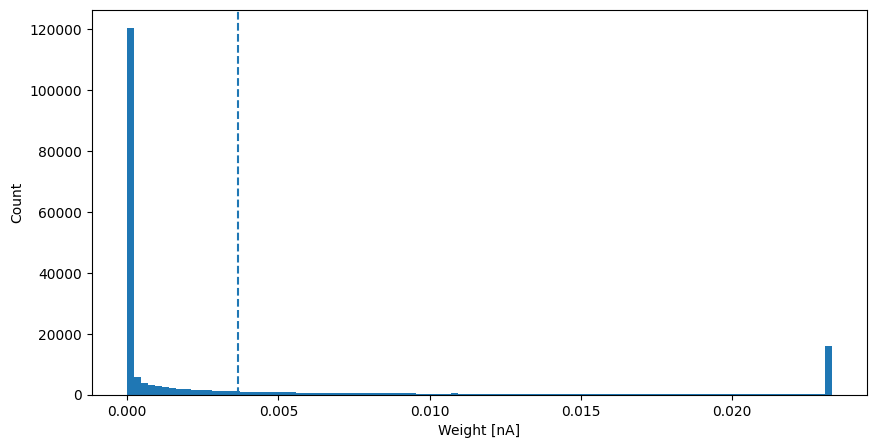

In [17]:
fig, axis = plt.subplots(figsize=(10, 5))
axis.hist(kc_mbon_g_view, bins=100)
axis.axvline(np.average(kc_mbon_g_view), linestyle="--")
axis.set_xlabel("Weight [nA]")
axis.set_ylabel("Count");

So we can reproduce exactly the same PN->KC connectivity again and reuse the weights we've learnt we want to save them back to YOUR google drive. First mount the drive

In [18]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Save the learnt weights

In [19]:
np.save("/content/drive/MyDrive/kc_mbon_g.npy", kc_mbon_g_view)

Download the PN->KC connectivity from the GPU and save the sparse connectivity.

In [20]:
pn_kc.pull_connectivity_from_device()
np.save("/content/drive/MyDrive/pn_kc_ind.npy", np.vstack((pn_kc.get_sparse_pre_inds(), pn_kc.get_sparse_post_inds())))